In [1]:
#!pip install mlrose_hiive

In [2]:
import mlrose_hiive as mlrose
import numpy as np
import matplotlib.pyplot as plt
import math
from multiprocessing import Pool
import functools

from tilemap_opt import *
from utils import *

plt.rcParams.update({'font.size': 16})

In [3]:
tilemap_constraints = TilemapConstraints.from_rules([
    ('sand', 'NESW', 'sand'),
    ('water', 'NESW', 'water'),
    
    ('sand_water_north', 'N', 'water'),
    ('sand_water_north', 'S', 'sand'),
    ('sand_water_north', 'EW', 'sand_water_north'),
    ('sand_water_north', 'E', 'sand_water_northeast'),
    ('sand_water_north', 'W', 'sand_water_northwest'),
    
    ('sand_water_east', 'E', 'water'),
    ('sand_water_east', 'W', 'sand'),
    ('sand_water_east', 'NS', 'sand_water_east'),
    ('sand_water_east', 'N', 'sand_water_northeast'),
    ('sand_water_east', 'S', 'sand_water_southeast'),
    
    ('sand_water_northeast', 'NE', 'water'),
    #('sand_water_northeast', 'SW', 'sand'),
    
    ('sand_water_south', 'S', 'water'),
    ('sand_water_south', 'N', 'sand'),
    ('sand_water_south', 'EW', 'sand_water_south'),
    ('sand_water_south', 'E', 'sand_water_southeast'),
    ('sand_water_south', 'W', 'sand_water_southwest'),
    
    ('sand_water_southeast', 'SE', 'water'),
    #('sand_water_southeast', 'NW', 'sand'),
    
    ('sand_water_west', 'W', 'water'),
    ('sand_water_west', 'E', 'sand'),
    ('sand_water_west', 'NS', 'sand_water_west'),
    ('sand_water_west', 'N', 'sand_water_northwest'),
    ('sand_water_west', 'S', 'sand_water_southwest'),
    
    ('sand_water_southwest', 'SW', 'water'),
    #('sand_water_southwest', 'NE', 'sand'),
    
    ('sand_water_northwest', 'NW', 'water'),
    #('sand_water_northwest', 'SE', 'sand')
])

In [4]:
# continue_iterating = state_fitness_callback(iteration=iters,
#                                                             attempt=attempts + 1,
#                                                             done=max_attempts_reached,
#                                                             state=problem.get_state(),
#                                                             fitness=problem.get_adjusted_fitness(),
#                                                             fitness_evaluations=problem.fitness_evaluations,
#                                                             curve=np.asarray(all_curves) if curve else None,
#                                                             user_data=callback_extra_data)


# state_fitness_callback(iteration=0,
#                                    state=problem.get_state(),
#                                    fitness=problem.get_adjusted_fitness(),
#                                    fitness_evaluations=problem.fitness_evaluations,
#                                    user_data=callback_extra_data)

def rhc_callback(iteration, state, fitness, fitness_evaluations, user_data, attempt=1,  done=False, curve=None):
    user_data = dict(user_data)
    cr = user_data['current_restart']
    if cr not in user_data['curve']:
        user_data['curve'][cr] = fitness
    if fitness > user_data['curve'][cr]:
        user_data['curve'][cr] = fitness
    return True

In [5]:

# MIMIC
four_peaks = mlrose.DiscreteOpt(length=64,
                                fitness_fn=mlrose.FourPeaks(),
                                maximize=True,
                                max_val=2)

# Random Hill Climbing + Simulated Annealing
count_ones = mlrose.DiscreteOpt(length=64,
                                fitness_fn=mlrose.OneMax(),
                                maximize=True,
                                max_val=2)

# Genetic Algorithm
tilemap = TilemapGeneration(size=(10, 10), constraints=tilemap_constraints)

ntrials = 1
starting_seed = 23435
seeds = list(range(starting_seed, starting_seed+ntrials+1))

max_iters = 100

problems = {
    'four_peaks': four_peaks,
    'count_ones': count_ones,
    'tilemap': tilemap
}

default_kwargs = {
    'curve': True,
    'max_iters': max_iters,
    'max_attempts': 10,
}

problem_specific_kwargs = {
    '*': {
        'random_hill_climb': {
            'restarts': 99
        },
        'simulated_annealing': {
            'schedule': mlrose.ExpDecay(),
        },
        'mimic': {
            'pop_size': 10000
        }
    },
    'tilemap': {
        'genetic_algorithm': {
            'pop_size': 10000,
            'mutation_prob': 0.25
        },
    }
}

algorithms = {
    'random_hill_climb': (mlrose.random_hill_climb, default_kwargs.copy()),
    'simulated_annealing': (mlrose.simulated_annealing, default_kwargs.copy()),
    'genetic_algorithm': (mlrose.genetic_alg, default_kwargs.copy()),
    'mimic': (mlrose.mimic, default_kwargs.copy())
}

for algorithm in algorithms:
    if algorithm in problem_specific_kwargs['*']:
        algorithms[algorithm][-1].update(problem_specific_kwargs['*'][algorithm])
    for problem in problems:
        if problem in problem_specific_kwargs and algorithm in problem_specific_kwargs[problem]:
            algorithms[algorithm][-1].update(problem_specific_kwargs[problem][algorithm])

In [6]:
st = time.time()

nrows = int(math.ceil(len(algorithms) / 2))
ncols = 2

results = {}

def execute_fn(problem, algorithm, kwargs, seed):
    problem.reset()
    st = time.time()
    _kwargs = {**kwargs, 'random_state': seed}
    best_state, best_fitness, fitness_curve = algorithm(problem, **_kwargs)
    et = time.time()
    return best_state, best_fitness, fitness_curve, et - st

async_results = []
with Pool(min(16, ntrials * len(problems) * len(algorithms))) as pool:
    for problem in problems:
        results[problem] = {}
        for algorithm in algorithms:
            fn, kwargs = algorithms[algorithm]

            results[problem][algorithm] = {
                'best_state': [],
                'best_fitness': [],
                'fitness_curve': [],
                'fevals': [],
                'runtime': []
            }
            
            fn = functools.partial(execute_fn, problems[problem], fn, kwargs)
            async_results.append((pool.map_async(fn, seeds), results[problem][algorithm]))
            
    for async_result in async_results:
        future, store = async_result
        for result in future.get():
            best_state, best_fitness, fitness_curve, runtime = result
            store['best_state'].append(best_state)
            store['best_fitness'].append(best_fitness)
            store['fitness_curve'].append(fitness_curve[:, 0])  
            store['fevals'].append(fitness_curve[:, 1])
            store['runtime'].append(runtime)

et = time.time()
print(f"runtime: {et - st}")

runtime: 964.1141037940979


In [7]:
# Compute Stats
stats = {}
for problem in problems:
    stats[problem] = {}
    for algorithm in algorithms:
        
        max_fitness_curve_len = max([len(x) for x in results[problem][algorithm]['fitness_curve']])
        curves = []
        for curve in results[problem][algorithm]['fitness_curve']:
            curves.append(np.pad(curve, (0, max_fitness_curve_len - len(curve)), constant_values=np.nan))
        curves = np.vstack(curves)
        
        max_fevals_len = max([len(x) for x in results[problem][algorithm]['fevals']])
        fevals = []
        for feval in results[problem][algorithm]['fevals']:
            fevals.append(np.pad(feval, (0, max_fevals_len - len(feval)), constant_values=np.nan))
        fevals = np.vstack(fevals)
        
        best_fitness = None
        best_state = None
        for i, fitness in enumerate(results[problem][algorithm]['best_fitness']):
            if best_fitness is None or fitness > best_fitness:
                best_fitness = fitness
                best_state = results[problem][algorithm]['best_state'][i]
                
        
        stats[problem][algorithm] = {
            'best_state': best_state,
            'best_fitness': best_fitness,
            'fitness_curve': np.nanmean(curves, axis=0),
            'fevals': np.nanmean(fevals, axis=0),
            'runtime': np.mean(results[problem][algorithm]['runtime'])
        }

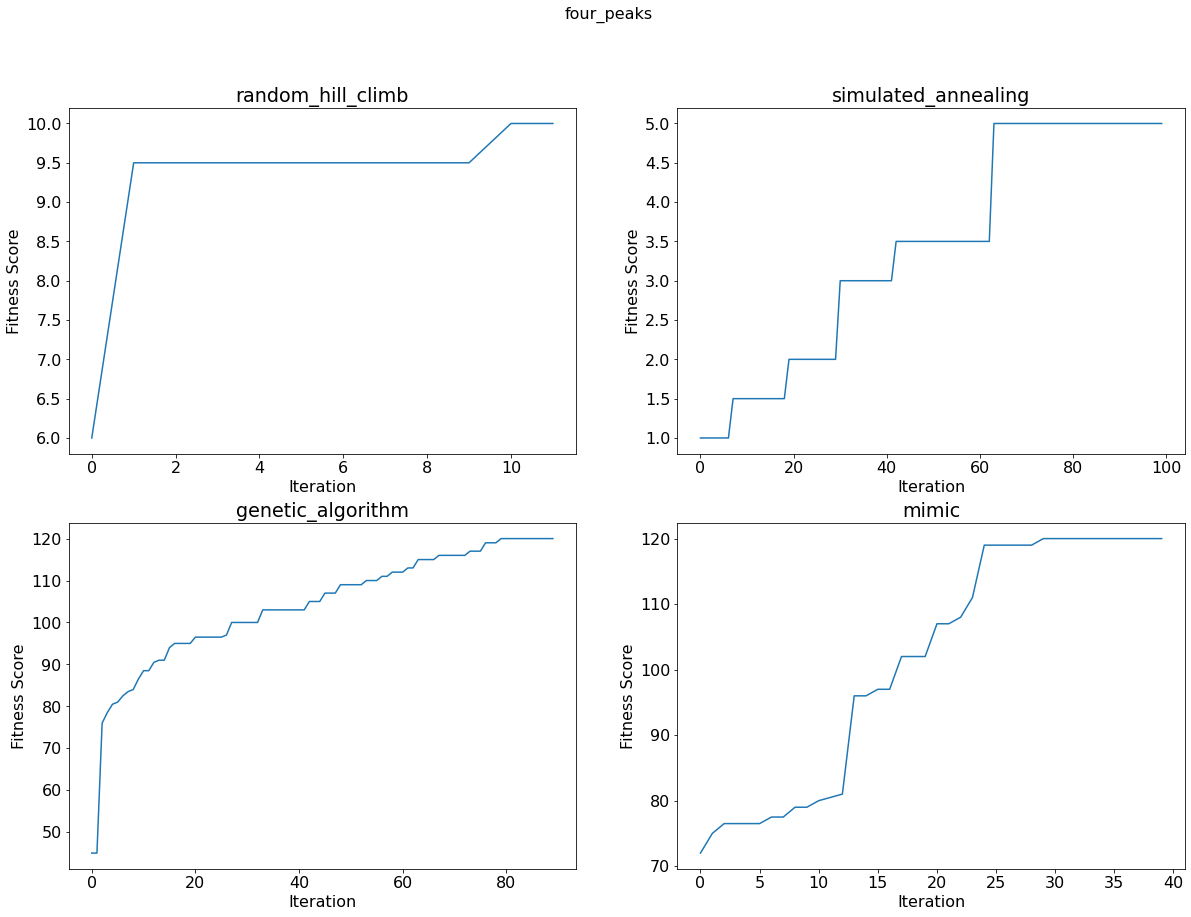

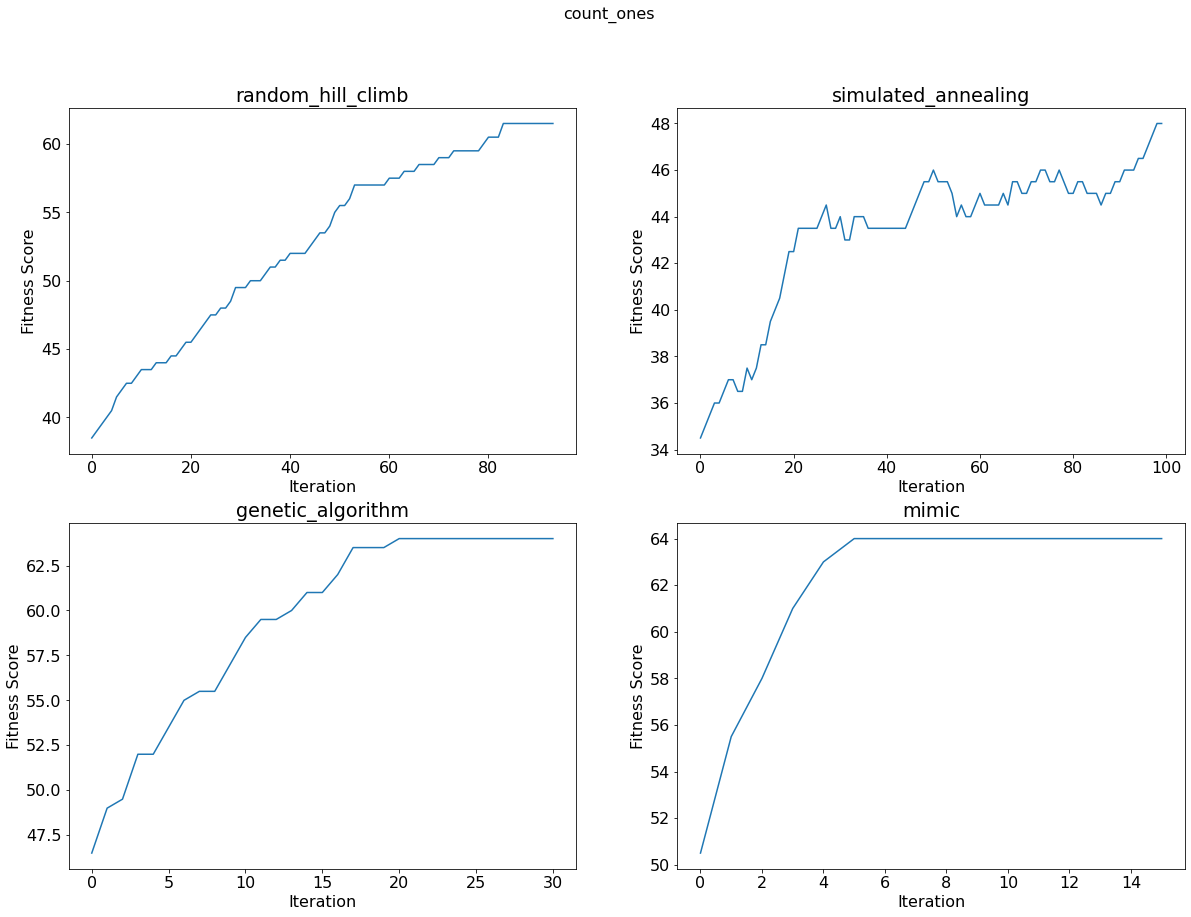

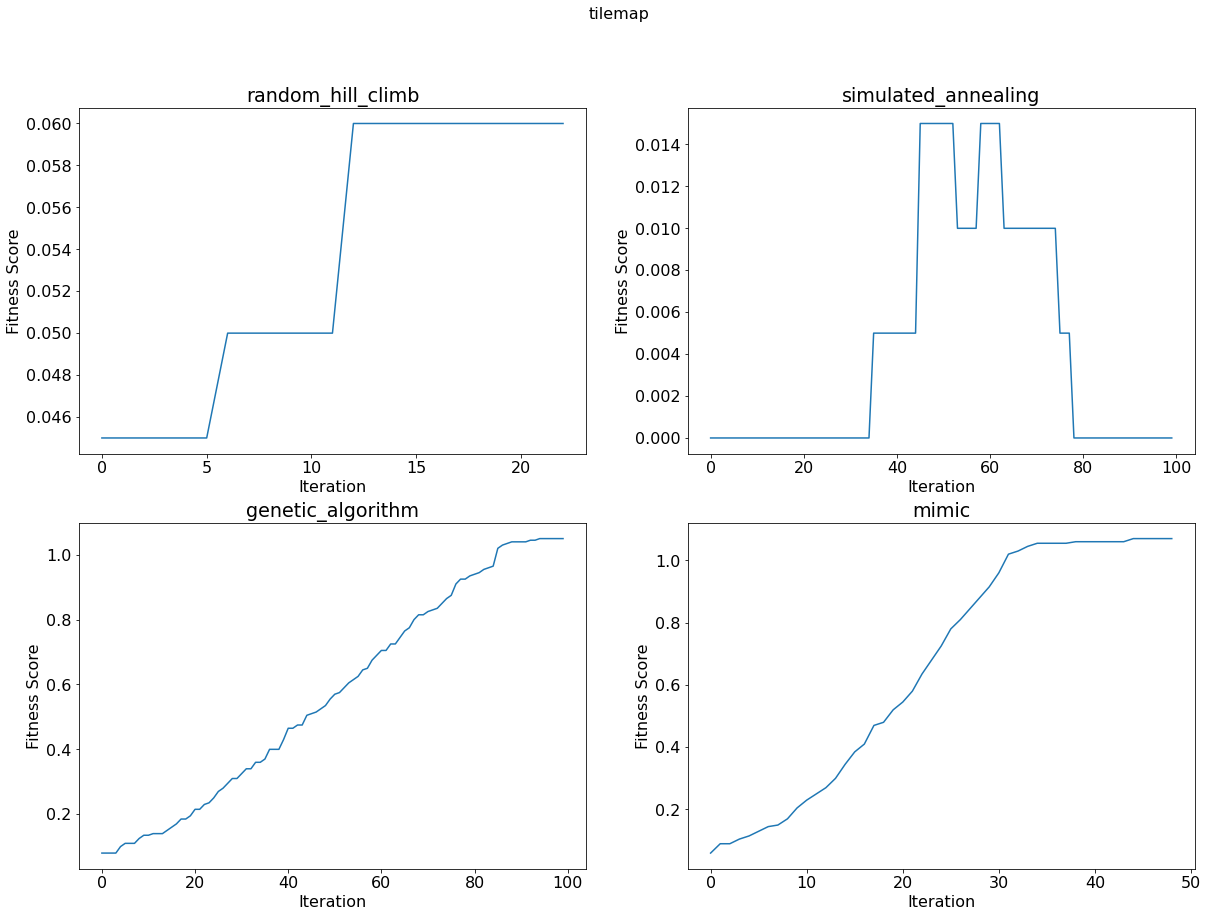

In [8]:
for problem in problems:
    fig, ax = plt.subplots(nrows, ncols, figsize=(20, 7 * nrows))
    fig.suptitle(problem, fontsize=16)
    for i, algorithm in enumerate(algorithms):
        y = i // ncols
        x = i % ncols
        _ax = ax[y, x] if len(algorithms) > 2 else ax[i]
        #_ax.plot(results[problem][algorithm]['fitness_curve'][:, 1], results[problem][algorithm]['fitness_curve'][:, 0])
        
        fitness = stats[problem][algorithm]['fitness_curve']
        iterations = list(range(len(fitness)))
        _ax.plot(fitness)
        #_ax.plot(results[problem][algorithm]['fitness_curve'][-1][:, 1], results[problem][algorithm]['fitness_curve'][-1][:, 0])
        _ax.set_title(algorithm)
        _ax.set_xlabel('Iteration')
        _ax.set_ylabel('Fitness Score')
    plt.show()

In [9]:
def render_table(row_labels, col_labels, cell_data, table_scale=(1, 4), **kwargs):
    fig, ax = plt.subplots(**kwargs)
    fig.patch.set_visible(False)
    ax.axis('off')
    ax.axis('tight')
    table = ax.table(
        cellText=cell_data, 
        rowLabels=col_labels, 
        colLabels=row_labels, 
        cellLoc='center',
        loc='upper left')
    table.set_fontsize(100)
    table.scale(*table_scale)
    #table.auto_set_font_size()
    fig.tight_layout()
    
    fig.show()
    return fig, ax

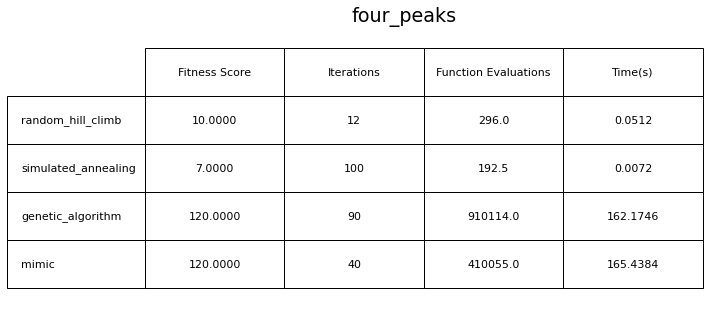

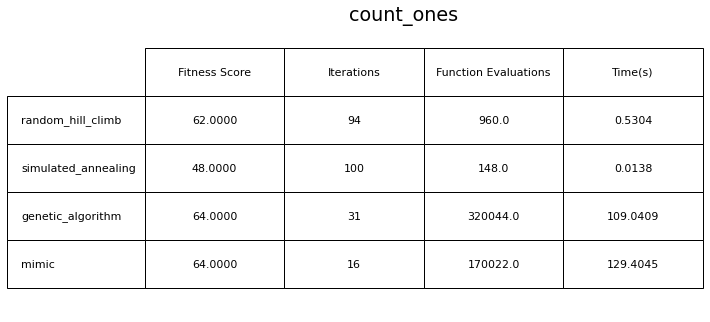

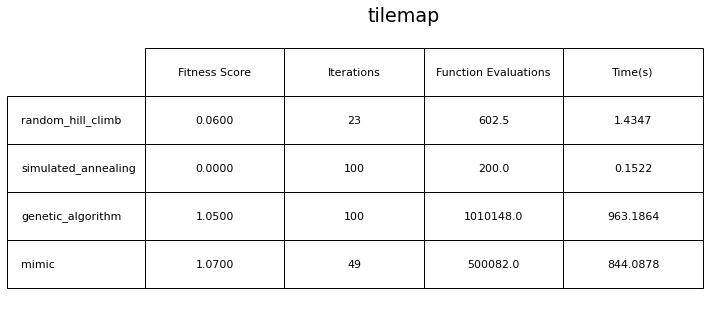

In [10]:
for problem in problems:
    row_labels = ['Fitness Score', 'Iterations', 'Function Evaluations', 'Time(s)']
    col_labels = list(algorithms)
    cell_data = np.full((len(algorithms), len(row_labels)), '', dtype=object)
    for i, algorithm in enumerate(algorithms):
        cell_data[i, 0] = '%.4f' % stats[problem][algorithm]['best_fitness']
        cell_data[i, 1] = stats[problem][algorithm]['fitness_curve'].shape[0]
        cell_data[i, 2] = stats[problem][algorithm]['fevals'].max()
        cell_data[i, 3] = '%.4f' % stats[problem][algorithm]['runtime']
    fig, ax = render_table(row_labels, col_labels, cell_data, table_scale=(1, 4), figsize=(10,5))
    fig.suptitle(problem)

(160, 160, 3)


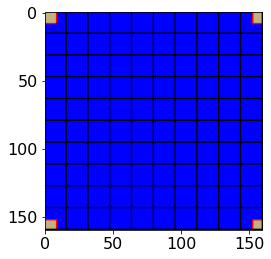

In [11]:
grass = (0, 1.0, 0)
sand = (0.76, 0.7, 0.5)
water = (0, 0, 1.0)

tilemap_images = {
    'grass': np.full((16, 16, 3), fill_value=grass),
    'sand': np.full((16, 16, 3), fill_value=sand),
    'water': np.full((16, 16, 3), fill_value=water),
}

tilemap_images['sand_water_north'] = np.full((16, 16, 3), fill_value=sand)
tilemap_images['sand_water_north'][:8, :, :] = water
tilemap_images['sand_water_north'][8, :, :] = (1.0, 0, 0)

tilemap_images['sand_water_east'] = np.full((16, 16, 3), fill_value=sand)
tilemap_images['sand_water_east'][:, 8:, :] = water
tilemap_images['sand_water_east'][:, 8, :] = (1.0, 0, 0)

tilemap_images['sand_water_south'] = np.full((16, 16, 3), fill_value=sand)
tilemap_images['sand_water_south'][8:, :, :] = water
tilemap_images['sand_water_south'][8, :, :] = (1.0, 0, 0)

tilemap_images['sand_water_west'] = np.full((16, 16, 3), fill_value=sand)
tilemap_images['sand_water_west'][:, :8, :] = water
tilemap_images['sand_water_west'][:, 8, :] = (1.0, 0, 0)

tilemap_images['sand_water_northeast'] = np.full((16, 16, 3), fill_value=water)
tilemap_images['sand_water_northeast'][8:, :8, :] = sand
tilemap_images['sand_water_northeast'][8, :8, :] = (1.0, 0, 0)
tilemap_images['sand_water_northeast'][8:, 8, :] = (1.0, 0, 0)

tilemap_images['sand_water_southeast'] = np.full((16, 16, 3), fill_value=water)
tilemap_images['sand_water_southeast'][:8, :8, :] = sand
tilemap_images['sand_water_southeast'][8, :8, :] = (1.0, 0, 0)
tilemap_images['sand_water_southeast'][:8, 8, :] = (1.0, 0, 0)

tilemap_images['sand_water_southwest'] = np.full((16, 16, 3), fill_value=water)
tilemap_images['sand_water_southwest'][:8, 8:, :] = sand
tilemap_images['sand_water_southwest'][:8, 8, :]= (1.0, 0, 0)
tilemap_images['sand_water_southwest'][8, 8:, :] = (1.0, 0, 0)

tilemap_images['sand_water_northwest'] = np.full((16, 16, 3), fill_value=water)
tilemap_images['sand_water_northwest'][8:, 8:, :] = sand
tilemap_images['sand_water_northwest'][8:, 8, :] = (1.0, 0, 0)
tilemap_images['sand_water_northwest'][8, 8:, :] = (1.0, 0, 0)

for k in tilemap_images:
    tilemap_images[k][15, :, :] = (0, 0, 0)
    tilemap_images[k][:, 15, :] = (0, 0, 0)


rasterizer = TilemapRasterizer(problems['tilemap'], tilemap_images)
img = rasterizer.rasterize(stats['tilemap']['genetic_algorithm']['best_state'])
print(img.shape)
plt.imshow(img)